# Predicting the Modifier Susceptibility

This notebook outlines the steps taken to predict the `is_modifier` column from a given dataset.

## Import Libraries

In [1]:
%reload_kedro

[11/23/23 21:58:09] INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=696722;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=122870;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[11/23/23 21:58:09] INFO     Kedro project ModSpy-Data                                              ]8;id=219496;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=907126;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=710770;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=409758;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [51]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import, division, print_function, unicode_literals

import os
import tempfile
import re
import sys
import itertools
from pathlib import Path
import warnings
import datetime

from loguru import logger
from joblib import dump, load
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import shutil
from urllib.request import Request, urlopen
import fastsemsim
import gemo.config as config
from gemo.features.build_features import filter_annotations, cook_dataset, batch_process


import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
from scipy.special import logit, expit
from scipy.stats import loguniform
from sklearn.metrics import *
from dotenv import find_dotenv, load_dotenv
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.conditional_models import ConditionalLogit
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split, GroupShuffleSplit, GridSearchCV, LeavePGroupsOut


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

## Data Preprocessing

In [99]:
# Load the dataset and drop columns with missing values
dataset = catalog.load("modifiers")
dataset_clean = dataset.dropna(axis=1)
dataset_clean.head()

[11/24/23 01:13:48] INFO     Loading data from 'modifiers' (CSVDataSet)...                      ]8;id=444902;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=864869;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

,target_gene_symbol,modifier_gene_symbol,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,go_lin_avg,go_lin_bma,go_jiang_max,go_jiang_avg,go_jiang_bma,go_jiang_seco_max,go_jiang_seco_avg,go_jiang_seco_bma,is_modifier,Sample
0,ATR,TERT,56.0,2.992471,8.027273,107.0,28.313613,76.984848,1.0,0.120300,...,0.265784,0.657466,1.0,0.063390,0.265030,1.0,0.180231,0.714237,1.0,JVL
1,BBS4,PCF11,11.0,2.779736,3.311688,73.0,27.040299,44.350649,1.0,0.145836,...,0.307401,0.358265,1.0,0.065845,0.127221,1.0,0.206274,0.473575,1.0,JVL
2,BBS4,USP35,8.0,2.072289,2.126761,59.0,22.190299,29.253521,1.0,0.145601,...,0.263192,0.250892,1.0,0.068862,0.130189,1.0,0.195530,0.375772,1.0,JVL
3,BRCA1,ASTE1,3.0,1.714286,2.437500,64.0,22.500000,24.573171,1.0,0.287505,...,0.348560,0.581542,1.0,0.077160,0.105624,1.0,0.299402,0.401114,1.0,JVL
4,CDK6,ERBB2,43.0,3.467509,9.188811,136.0,27.932018,78.384615,1.0,0.142690,...,0.306914,0.713913,1.0,0.071939,0.334014,1.0,0.256735,0.784365,1.0,JVL


In [100]:
# Split the data into features and target
X = dataset_clean.drop(['is_modifier'], axis=1)
y = dataset_clean['is_modifier']

# Select only numerical features
X_numeric = X.select_dtypes(include=['float64'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.40, random_state=42, stratify=y)

## Feature Selection

In [96]:
id_cols = [
    'Sample',
    'gene_symbol',
    'target_gene_symbol', 
    'modifier_gene_symbol',
]
non_feat_cols = [    
    'chromosome',
    'position',
    'ref',
    'alt',
    'wormbase_gene_id',    
    'gene_start_position',
    'gene_end_position',
    'variant_id',
    'target_gene_id',
    'target_gene_symbol',
    'protein1',
    'protein2'
]
# non feature column from JVL-MTG merged dataset
non_feat_extra = [
    'QueryGene', 'SuppressorGene', 'QueryGene_norm',
    'SuppressorGene_norm', 'protein_x', 'alias_x', 'source_x',
    'alias_norm_x', 'protein_y', 'alias_y', 'source_y', 'alias_norm_y',
    'protein1', 'protein2', 'Sample', 'strain',
    'chromosome'
]
target_attr = 'is_modifier'
sim_methods = ['Resnik', 'Lin', 'Jiang-Conrath',
               'SimRel', 'SimIC', 'G-SESAME', 'SimICND', 'SimICNP']
mix_methods = ['max', 'BMA', 'avg']
method_combs = list(itertools.product(sim_methods, mix_methods))
ontos = ['go', 'wpo', 'wpo_not']

In [97]:
train_ids = [26, 27, 28, 30, 34, 37, 76, 105, 120, 121, 139]
train_samples = ["MTG"+str(n) for n in train_ids]
train = dataset_clean[dataset_clean['Sample'].isin(train_samples)]
test = dataset_clean[~dataset_clean['Sample'].isin(train_samples)]
print("Training size: {}".format(train.shape[0]))
print("Testing size: {}".format(test.shape[0]))

Training size: 762
Testing size: 7101


In [75]:
# Training data as numpy array
train_arr = train[train.columns.difference(id_cols+non_feat_cols+non_feat_extra+[target_attr])].to_numpy()
train_y = train[target_attr].to_numpy()
print(f"Training shpae: {train_arr.shape}")

# Testing data as numpy array
test_arr = test[test.columns.difference(id_cols+non_feat_cols+non_feat_extra+[target_attr])].to_numpy()
test_y = test[target_attr].to_numpy()
print(f"Testing shpae: {test_arr.shape}")

Training shpae: (762, 27)
Testing shpae: (7101, 27)


In [55]:
non_feat_cols += non_feat_extra
corr = train[train.columns.difference(id_cols+non_feat_cols)].corr(method='spearman')

In [56]:
def get_origin(row):
    # print(row)
    m = re.search('(go|wpo_not|wpo)', row['Features'])
    if m:
        return m.group(0)
    else:
        return 'interaction'

In [87]:
dataset_clean.columns

Index(['target_gene_symbol', 'modifier_gene_symbol',
       'go_n_common_ancestors_max', 'go_n_common_ancestors_avg',
       'go_n_common_ancestors_bma', 'go_n_union_ancestors_max',
       'go_n_union_ancestors_avg', 'go_n_union_ancestors_bma', 'go_batet_max',
       'go_batet_avg', 'go_batet_bma', 'go_batet_log_max', 'go_batet_log_avg',
       'go_batet_log_bma', 'go_resnik_max', 'go_resnik_avg', 'go_resnik_bma',
       'go_resnik_scaled_max', 'go_resnik_scaled_avg', 'go_resnik_scaled_bma',
       'go_lin_max', 'go_lin_avg', 'go_lin_bma', 'go_jiang_max',
       'go_jiang_avg', 'go_jiang_bma', 'go_jiang_seco_max',
       'go_jiang_seco_avg', 'go_jiang_seco_bma', 'is_modifier', 'Sample'],
      dtype='object')

In [88]:
cols = ['go_n_common_ancestors_max', 'go_n_union_ancestors_max', 
        'go_batet_max', 'go_resnik_max', 'go_lin_max']

In [89]:
grouping_col = 'Sample'
id_cols = ['Sample','modifier_gene_symbol','target_gene_symbol']
# cols = list(sel_feats['Features'])
models = []
groups = set(dataset_clean[grouping_col].values)
cleaned_df = dataset_clean.fillna(0)
# cleaned_df['combined_score'] = cleaned_df['combined_score']/1000

cleaned_df.fillna(0, inplace=True)
# cleaned_df[target_attr] = cleaned_df[target_attr].values.astype(int)
train_ids = [26, 27, 28, 30, 34, 37, 76, 105, 120, 121, 139]
train_samples = ["MTG"+str(n) for n in train_ids]
id_train = cleaned_df[cleaned_df[grouping_col].isin(train_samples)][id_cols]
id_test = cleaned_df[~cleaned_df[grouping_col].isin(train_samples)][id_cols]
X_train = cleaned_df[cleaned_df[grouping_col].isin(train_samples)][cols]
X_test = cleaned_df[~cleaned_df[grouping_col].isin(train_samples)][cols]
y_train = cleaned_df[cleaned_df[grouping_col].isin(train_samples)][target_attr]
y_test = cleaned_df[~cleaned_df[grouping_col].isin(train_samples)][target_attr]

# X_train, X_test, y_train, y_test = data_split(cleaned_df, cols, 'is_modifier')
print("# of training samples:{} ({}%)".format(len(X_train), (100*len(X_train)/(len(X_train)+len(X_test))) ))
print("# of testing samples:{} ({}%)".format(len(X_test), (100*len(X_test)/(len(X_train)+len(X_test))) ))

# of training samples:762 (9.690957649752002%)
# of testing samples:7101 (90.30904235024799%)


In [101]:
# Initialize a random forest classifier and fit it to the training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Use SelectFromModel for feature selection
sfm = SelectFromModel(rf_classifier, threshold='mean', max_features=4)
sfm.fit(X_train, y_train)

# Select the important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

print(f"Selected training set shape: {X_important_train.shape}")
print(f"Selected testing set shape: {X_important_test.shape}")

mask = sfm.get_support()
selected_features = np.array(X_train.columns)[mask]
print(selected_features)

Selected training set shape: (4717, 4)
Selected testing set shape: (3146, 4)
['go_resnik_max' 'go_resnik_bma' 'go_jiang_seco_max' 'go_jiang_seco_avg']


## Model Building and Evaluation

In [126]:
# Train a new random forest classifier on the important features
rf_classifier_v02 = RandomForestClassifier(n_estimators=3, random_state=42, class_weight='balanced')
rf_classifier_v02.fit(X_important_train, y_train)

# Predict the target for the test set
y_pred_rf_v02 = rf_classifier_v02.predict(X_important_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf_v02)
classification_rep = classification_report(y_test, y_pred_rf_v02)
accuracy, classification_rep

(0.9783852511125238,
 '              precision    recall  f1-score   support\n\n         0.0       0.99      0.99      0.99      2927\n         1.0       0.87      0.81      0.84       219\n\n    accuracy                           0.98      3146\n   macro avg       0.93      0.90      0.91      3146\nweighted avg       0.98      0.98      0.98      3146\n')

In [127]:
# Train a new random forest classifier on the important features
rf_classifier_v03 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier_v03.fit(X_important_train, y_train)

# Predict the target for the test set
y_pred_rf_v03 = rf_classifier_v03.predict(X_important_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf_v03)
classification_rep = classification_report(y_test, y_pred_rf_v03)
accuracy, classification_rep

(0.9841068022886205,
 '              precision    recall  f1-score   support\n\n         0.0       0.99      1.00      0.99      2927\n         1.0       0.95      0.81      0.88       219\n\n    accuracy                           0.98      3146\n   macro avg       0.97      0.90      0.93      3146\nweighted avg       0.98      0.98      0.98      3146\n')

In [128]:
# Train a new random forest classifier on the important features
lr_classifier_v01 = LogisticRegression(C=0.9192796263326164, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            n_jobs=None, penalty='l1', random_state=500,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
lr_classifier_v01.fit(X_important_train, y_train)

# Predict the target for the test set
y_pred_lr_v01 = lr_classifier_v01.predict(X_important_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr_v01)
classification_rep = classification_report(y_test, y_pred_lr_v01)
accuracy, classification_rep

(0.8766687857596949,
 '              precision    recall  f1-score   support\n\n         0.0       0.99      0.87      0.93      2927\n         1.0       0.35      0.92      0.51       219\n\n    accuracy                           0.88      3146\n   macro avg       0.67      0.90      0.72      3146\nweighted avg       0.95      0.88      0.90      3146\n')

Epoch 1/100


148/148 [==============================] - 2s 5ms/step - loss: 0.4094 - auc_2: 0.0383 - val_loss: 0.3330 - val_auc_2: 0.0413
Epoch 2/100
148/148 [==============================] - 0s 3ms/step - loss: 0.2698 - auc_2: 0.0688 - val_loss: 0.2115 - val_auc_2: 0.5442
Epoch 3/100
148/148 [==============================] - 0s 3ms/step - loss: 0.1883 - auc_2: 0.4114 - val_loss: 0.1681 - val_auc_2: 0.5664
Epoch 4/100
148/148 [==============================] - 0s 3ms/step - loss: 0.1656 - auc_2: 0.4715 - val_loss: 0.1534 - val_auc_2: 0.5439
Epoch 5/100
148/148 [==============================] - 0s 3ms/step - loss: 0.1546 - auc_2: 0.5128 - val_loss: 0.1486 - val_auc_2: 0.5475
Epoch 6/100
148/148 [==============================] - 0s 3ms/step - loss: 0.1503 - auc_2: 0.5647 - val_loss: 0.1454 - val_auc_2: 0.5728
Epoch 7/100
148/148 [==============================] - 0s 3ms/step - loss: 0.1505 - auc_2: 0.5488 - val_loss: 0.1464 - val_auc_2: 0.5645
Epoch 8/100
148/148 [==============================] 

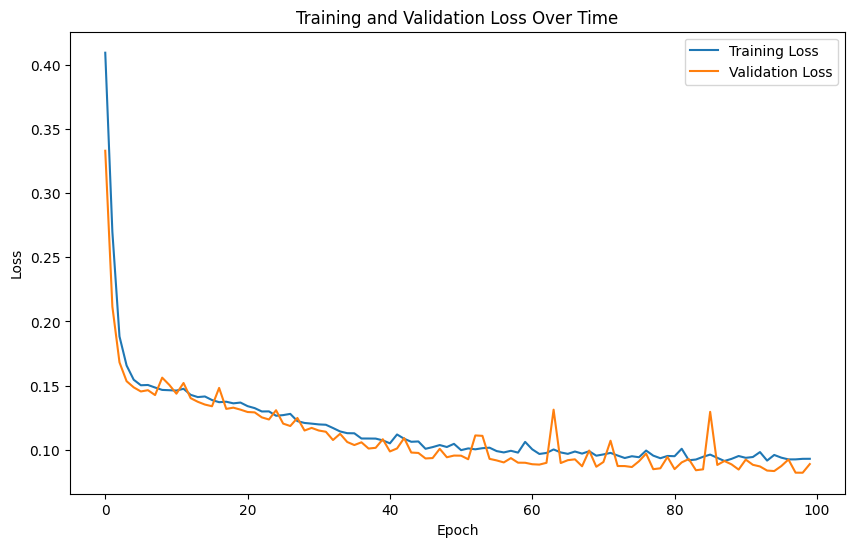

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC, TruePositives, Precision, Recall

# Define the model
nn_classifier = Sequential()
nn_classifier.add(Dense(32, input_dim=X_important_train.shape[1], activation='relu'))  # Input layer
nn_classifier.add(Dense(16, activation='relu'))  # Hidden layer
nn_classifier.add(Dense(8, activation='relu'))  # Hidden layer
nn_classifier.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
nn_classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(curve='PR')])

# Fit the model
history = nn_classifier.fit(X_important_train, y_train, epochs=100, batch_size=32, validation_data=(X_important_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## PR Curve

99/99 [==============================] - 0s 1ms/step


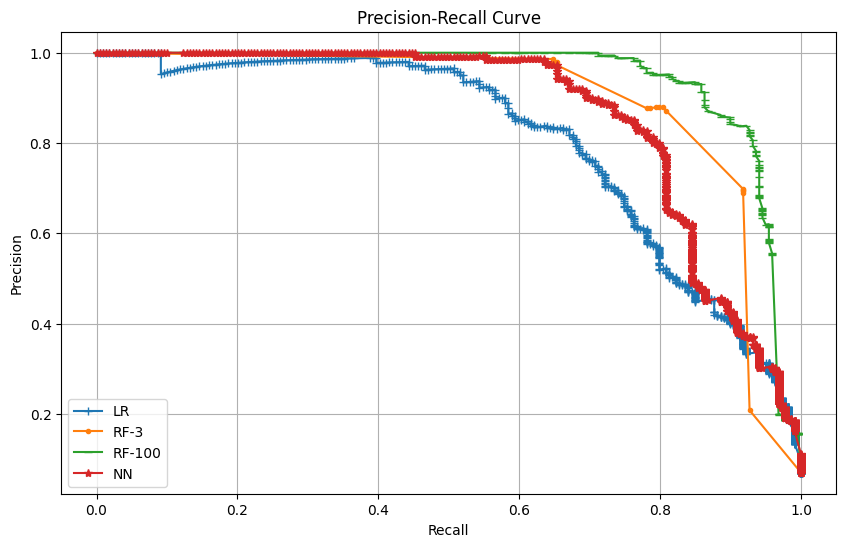

In [135]:
# Compute precision-recall pairs for different probability thresholds
y_scores_lr_v01 = lr_classifier_v01.predict_proba(X_important_test)[:, 1]
y_scores_rf_v02 = rf_classifier_v02.predict_proba(X_important_test)[:, 1]
y_scores_rf_v03 = rf_classifier_v03.predict_proba(X_important_test)[:, 1]
y_scores_nn_v03 = nn_classifier.predict(X_important_test)

precision_1, recall_1, _ = precision_recall_curve(y_test, y_scores_lr_v01)
precision_2, recall_2, _ = precision_recall_curve(y_test, y_scores_rf_v02)
precision_3, recall_3, _ = precision_recall_curve(y_test, y_scores_rf_v03)
precision_4, recall_4, _ = precision_recall_curve(y_test, y_scores_nn_v03)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_1, precision_1, marker='+', label='LR')
plt.plot(recall_2, precision_2, marker='.', label='RF-3')
plt.plot(recall_3, precision_3, marker='_', label='RF-100')
plt.plot(recall_4, precision_4, marker='*', label='NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


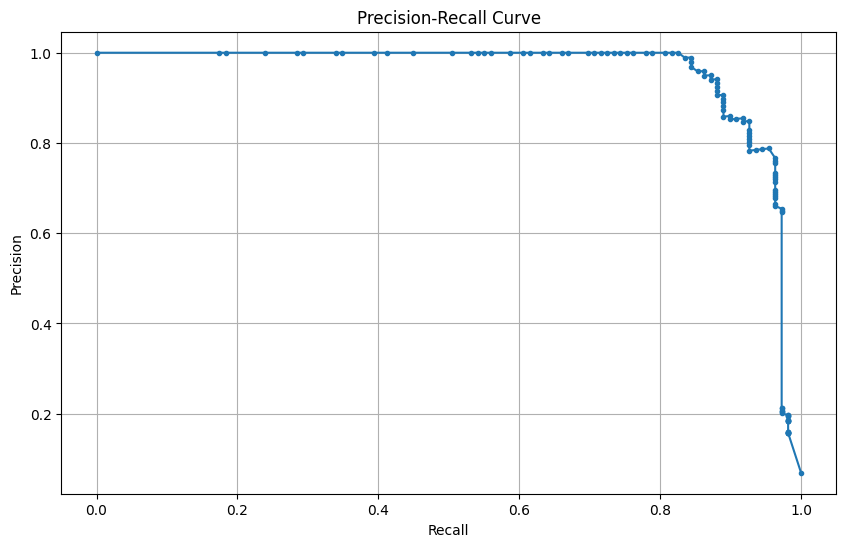

In [ ]:
# Compute precision-recall pairs for different probability thresholds
y_scores = rf_classifier_important.predict_proba(X_important_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
